### ANALISIS EXPLORATORIO



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#librerias
import pandas as pd
import matplotlib.pyplot as plot
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import numpy as np
from datetime import date, datetime, timedelta
from os import name

Definición de parámetros iniciales

In [ ]:
NUM_OF_WEEK = 8.0
HOURS_OF_DAY = 24
DAYS_OF_WEEK = 7
FORMAT_DATE = '%Y-%m-%d'

TRAINIG_DAY = pd.to_datetime("2022-04-01", format=FORMAT_DATE)
LAST_TRAINIG_DATE = TRAINIG_DAY - timedelta(weeks=NUM_OF_WEEK)

In [ ]:
#Nombre de ficheros
fichero_parquet = '/content/drive/MyDrive/Proyectos/Taxis libres/IA/Datos/SERVICIO_UNIFICADO_2022.parquet.gzip'

#Se lee el archivo de un parquet a un dataframe
df = pd.read_parquet(fichero_parquet) 

print("Dataset cargado con éxito")

Dataset cargado con éxito


Validamos cuantos valores nulos tenemos en el dataset

In [ ]:
#Contar cuantos datos se encuentran nulos
df.isnull().sum()

ID                       0
IDCIUDAD                 0
USUARIO               1707
TELEFONOORIGEN       69322
LATITUD                  0
LATITUDDESTINO     1932690
LONGITUD                 0
LONGITUDDESTINO    1932690
ESTADO                   0
ORIGEN                   0
FECHACOMPLETA            0
DIADESEMANA              0
HORA                     0
dtype: int64

Se limpian los datos donde el teléfono del usuario es nulo
 para tener usuarios validos y limitamos los datos de bogotá

In [ ]:
df.head(5)

,ID,IDCIUDAD,USUARIO,TELEFONOORIGEN,LATITUD,LATITUDDESTINO,LONGITUD,LONGITUDDESTINO,ESTADO,ORIGEN,FECHACOMPLETA,DIADESEMANA,HORA
0,70152580,11001,8946882.0,3186429637,4.642036,4.630580,-74.187636,-74.189880,CANCELADO,APP,2022-04-30 19:00:00,7,19
1,70152581,11001,9665930.0,3209171095,4.594340,4.604060,-74.138168,-74.141610,ABANDONADO,APP,2022-04-30 19:00:00,7,19
2,70152582,76001,9243481.0,3147558713,3.367783,NaN,-76.531083,NaN,ABANDONADO,APP,2022-04-30 19:00:01,7,19
3,70152583,11001,841805.0,3125733084,4.630927,NaN,-74.092728,NaN,ABANDONADO,CHAT_BOT_659,2022-04-30 19:00:01,7,19
4,70152584,11001,9330612.0,3043963812,4.548637,4.622711,-74.096414,-74.147018,ABANDONADO,APP,2022-04-30 19:00:01,7,19


In [ ]:
#Eliminamos los registros nulos del telefono de origen
df = df[~df['TELEFONOORIGEN'].isnull()]
#Filtramos por ciudad de bogotá
df = df[df["IDCIUDAD"]==11001]
#Se agrupan por teléfono para validar para identificar la cantidad de servicios tomados
df.loc[:,['TELEFONOORIGEN']].value_counts()

TELEFONOORIGEN
3166190342        2259
3107584482        2055
3057089507        1896
3115590650        1789
3138647901        1618
                  ... 
3133790144           1
3133790592           1
3133790851           1
3133791159           1
999883673            1
Length: 520899, dtype: int64

In [ ]:
#Calcular outlayer
cuenta = df.loc[:,['TELEFONOORIGEN']].value_counts()

In [ ]:
q1 = cuenta.quantile(0.25)
q3 = cuenta.quantile(0.75)
iqr = q3 - q1
print(q1, " - ", q3, " - ",iqr)

2.0  -  12.0  -  10.0


In [ ]:
#@title Default title text
outlayers_treshold = q3 + 3 * iqr
print(outlayers_treshold)
sum(cuenta>outlayers_treshold) 

42.0


37987

Probar con k-means y KNN para buscar los grupos de usuarios

Limitamos los canales por donde se reciben servicios a APP, IVR, CHATBOT, RECEPCIÓN, CALLE Y WEB que son los más relevantes.
Limitamos los estados a ABANDONADO, CUMPLIDO, CANCELADO Y FINALIZADO que son los validos, el restos son errores del proceso.

In [ ]:
df = df[(df["ORIGEN"]=="APP") | (df["ORIGEN"]=="IVR") | (df["ORIGEN"]=="CHAT_BOT_659") | (df["ORIGEN"]=="RECEPCION") | (df["ORIGEN"]=="CALLE") | (df["ORIGEN"]=="WEB")]
df = df[(df["ESTADO"]=="ABANDONADO") | (df["ESTADO"]=="CUMPLIDO") | (df["ESTADO"]=="CANCELADO") | (df["ESTADO"]=="FINALIZADO")]

Eliminamos las columnas de ciudad, usuario, id servicio, latitud y longitud de destino

In [ ]:
#Eliminamos las columan que no son útiles en el modelo
df = df.drop(columns=["IDCIUDAD","USUARIO","ID","LATITUDDESTINO","LONGITUDDESTINO","LATITUD","LONGITUD"])
#Se crea un campo de fecha para indexar

df['FECHACOMPLETA'] = pd.to_datetime(df['FECHACOMPLETA'], format='%Y/%m/%d %H:%M:%S')
df['DIADESEMANA'] = df['FECHACOMPLETA'].map( lambda x: x.isoweekday() )

#df['FECHA_HORA'] = fecha.dt.strftime("%Y-%m-%d %H")
#df['FECHA'] = fecha.dt.strftime("%Y-%m-%d")

Transformamos el valor de origen y estado a no ordinales con onehot.

In [ ]:
# convertimos a  onehot la comuna de origen
#df = pd.get_dummies(df, columns=["ORIGEN"])
# convertimos a  onehot la comuna de estado
#df = pd.get_dummies(df, columns=["ESTADO"])
"""new_df['ORIGEN'] = new_df['ORIGEN'].map( {
        "APP":1,
        "CALLE":2,
        "CHAT_BOT_659":3,
        "CHAT_BOT_689":4,
        "CHAT_BOT_729":5,
        "CHAT_BOT_803":6,
        "EXTERNO":7,
        "IONTAXI":8,
        "IVR":9,
        "NUEVO":10,
        "RECEPCION":11,
        "RED AMARILLA":12,
        "Reserva":13,
        "TELEGRAMTD":14,
        "WEB":15
    } )

new_df['ESTADO'] = new_df['ESTADO'].map( {
        "ABANDONADO":1,
        "ABORDOCONFIRMADO":2,
        "ALFRENTE":3,
        "ASIGNADO": 4,
        "CANCELADO":5,
        "CONFIRMADO":6,
        "CUMPLIDO":7,
        "FINALIZADO": 8,
        "LOCUCION":9,
        "NUEVO":10,
        "RECHAZADO":11
    } )"""
df.head(5)

,TELEFONOORIGEN,ESTADO,ORIGEN,FECHACOMPLETA,DIADESEMANA,HORA
0,3186429637,CANCELADO,APP,2022-04-30 19:00:00,6,19
1,3209171095,ABANDONADO,APP,2022-04-30 19:00:00,6,19
3,3125733084,ABANDONADO,CHAT_BOT_659,2022-04-30 19:00:01,6,19
4,3043963812,ABANDONADO,APP,2022-04-30 19:00:01,6,19
5,3113623140,ABANDONADO,APP,2022-04-30 19:00:02,6,19


Se particionan los datos en test y train

In [ ]:
#train = df[df['FECHACOMPLETA'] < pd.to_datetime("2022-04-01", format='%Y-%m-%d')]
#test = df[df['FECHACOMPLETA'] > pd.to_datetime("2022-04-01", format='%Y-%m-%d')]

In [ ]:
#train.head(5)

In [ ]:
#test.head(5)

# Probando con función probabilistica

In [ ]:
def findRow(pdate, phour, data):
  for row in data:
    if( ( row[3] == pdate.strftime(FORMAT_DATE) ) & ( row[2] == phour ) ):
      return row
  return []

def completeServices(data):
  first = pd.to_datetime(data.tail(1).iloc[0,3], format=FORMAT_DATE)
  last = pd.to_datetime(data.head(1).iloc[0,3], format=FORMAT_DATE)
  remaining_days = first.date() - last.date()
  phone = data.tail(1).iloc[0,0]
  data_array = data.to_numpy()
  new_array = []
  for i in range(remaining_days.days+1):
    last_time = last + timedelta(days=i)
    for day in range(HOURS_OF_DAY):
      new_row = findRow(last_time.date(), day, data_array)
      if len(new_row) > 0:
        new_array.append(np.append(new_row, 1))
      else:
        new_array.append([phone, last_time.isoweekday(),day,last_time.date().strftime(FORMAT_DATE),0])
  return pd.DataFrame(new_array, 
             columns=['TELEFONOORIGEN', 
                      'DIADESEMANA', 'HORA','FECHA','SERVICIO'])

In [ ]:
df_mp = df.copy()

#df_mp = df_mp[df_mp["TELEFONOORIGEN"]=="3115590650"]
df_mp['FECHA'] = df_mp['FECHACOMPLETA'].dt.strftime(FORMAT_DATE)
df_mp = df_mp.drop(columns=["FECHACOMPLETA","ORIGEN","ESTADO"])

#Se eliminan los duplicados
df_mp = df_mp.drop_duplicates().sort_values(by=['FECHA','DIADESEMANA','HORA'])
df_mp = df_mp.reset_index(drop=True)

#Se llenan los datos faltantes
#df_mp = completeServices(df_mp)

In [ ]:
df_mp.head(5)

,TELEFONOORIGEN,DIADESEMANA,HORA,FECHA
0,3124567009,5,19,2021-12-31
1,3214021236,5,19,2021-12-31
2,3212101273,5,19,2021-12-31
3,3209537009,5,19,2021-12-31
4,3196886712,5,19,2021-12-31


In [ ]:
df_mp.loc[:,['TELEFONOORIGEN']].value_counts()

TELEFONOORIGEN
3107584482        783
3138647901        684
3153865158        684
3134579964        642
13148180          628
                 ... 
3125329815          1
3125330004          1
3125330436          1
3125330453          1
999883673           1
Length: 517850, dtype: int64

In [ ]:
#Se filtran tomando solo los últimas x semanas
train = df_mp[ (pd.to_datetime(df_mp['FECHA'], format=FORMAT_DATE) < TRAINIG_DAY) & (pd.to_datetime(df_mp['FECHA'], format=FORMAT_DATE) > LAST_TRAINIG_DATE) ]#
test = df_mp[pd.to_datetime(df_mp['FECHA'], format=FORMAT_DATE) >= TRAINIG_DAY ]

train.head(5)

,TELEFONOORIGEN,DIADESEMANA,HORA,FECHA,SERVICIO
864,3115590650,6,0,2022-02-05,0
865,3115590650,6,1,2022-02-05,0
866,3115590650,6,2,2022-02-05,0
867,3115590650,6,3,2022-02-05,0
868,3115590650,6,4,2022-02-05,0


Se muestra la probabilidad de un usuario con los datos de entrenamiento

In [ ]:
def calculateProbability(hour, day, data):
  data_array = data.to_numpy()

  first = pd.to_datetime(data.tail(1).iloc[0,3], format=FORMAT_DATE)
  last = pd.to_datetime(data.head(1).iloc[0,3], format=FORMAT_DATE)
  remaining_days = first.date() - last.date()

  total = 0 
  for i in range(remaining_days.days+1):
    last_time = last + timedelta(days=i)
    if last_time.isoweekday() == day:
      total += 1
  
  total_onset = 0
  for row in data_array:
    if( ( row[1] == day ) & ( row[2] == hour ) & ( row[4] == 1 ) ):
      total_onset += 1
  if total > 0:
    return total_onset / total
  else:
    return 0

In [ ]:
def calculateProbabilisticModel(dataFrame):
  array_date_of_week = []
  for day in range(DAYS_OF_WEEK):
    array_hours = []
    for hour in range(HOURS_OF_DAY):
      array_hours.append( calculateProbability(hour, day+1, dataFrame))
    array_date_of_week.append(array_hours)
  return pd.DataFrame(np.array(array_date_of_week),
                    columns=[h for h in range(HOURS_OF_DAY)], index=["1-Monday","2-Tuesday","3-Wednesday","4-Thursday","5-Friday","6-Saturday","7-Sunday"],).transpose()

Se prueba con los datos de entrenamiento

In [ ]:
calculateProbabilisticModel(train)

,1-Monday,2-Tuesday,3-Wednesday,4-Thursday,5-Friday,6-Saturday,7-Sunday
0,0.000,0.000,0.000,0.000,0.000000,0.000,0.000
1,0.000,0.000,0.000,0.000,0.000000,0.000,0.000
2,0.000,0.000,0.000,0.000,0.000000,0.000,0.000
3,0.000,0.000,0.000,0.000,0.000000,0.000,0.000
4,0.000,0.000,0.000,0.000,0.000000,0.000,0.000
5,0.000,0.000,0.000,0.000,0.000000,0.000,0.000
6,0.000,0.000,0.000,0.000,0.000000,0.000,0.000
7,0.000,0.000,0.000,0.000,0.000000,0.000,0.000
8,0.000,0.000,0.000,0.000,0.000000,0.000,0.000
9,0.000,0.000,0.000,0.000,0.000000,0.000,0.000


Se valida con los datos de pruebas

In [ ]:
calculateProbabilisticModel(test)

,1-Monday,2-Tuesday,3-Wednesday,4-Thursday,5-Friday,6-Saturday,7-Sunday
0,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000
1,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000
2,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000
3,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000
4,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000
5,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000
6,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000
7,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000
8,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000
9,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000


# Exploración inicial

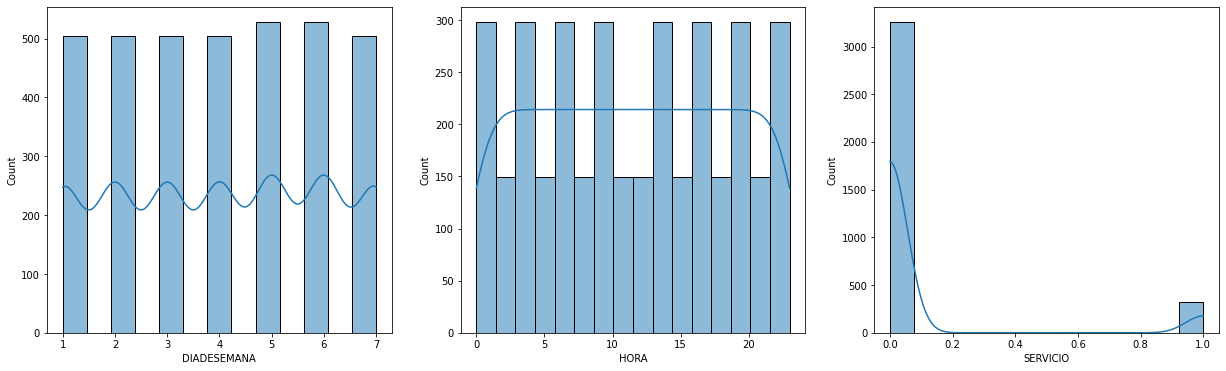

In [ ]:
df_reg = df_mp.copy()
df_reg = df_reg.drop(columns=['TELEFONOORIGEN','FECHA'])
fig, axes = plot.subplots(1, 3)
fig.set_size_inches(21,6)
for i, column in enumerate(df_reg.columns):
  sns.histplot(df_reg[column], kde=True, ax=axes[i])

Se genera un diagrama de dispersión

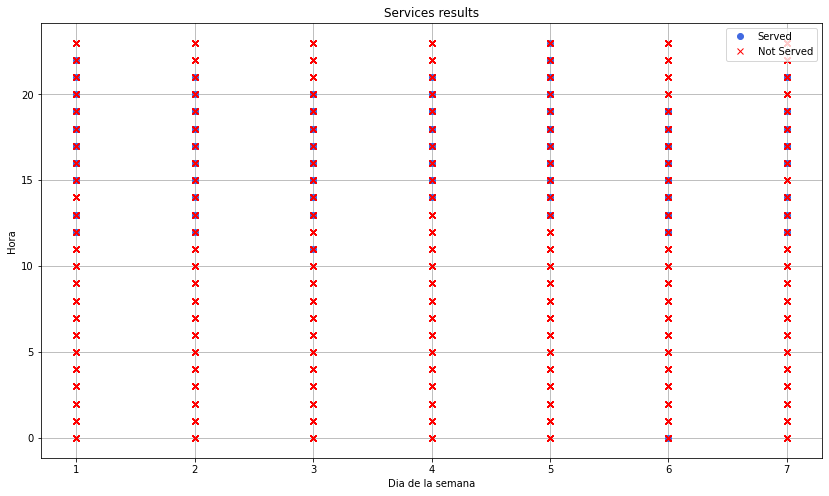

In [ ]:
served = df_reg[df_reg.SERVICIO == 1]
not_served = df_reg[df_reg.SERVICIO == 0]

plot.figure(figsize=(14, 8))
plot.plot(served['DIADESEMANA'].values, served['HORA'].values, linestyle='', marker='o', color='royalblue', label='Served')
plot.plot(not_served['DIADESEMANA'].values, not_served['HORA'].values, linestyle='', marker='x', color='r', label='Not Served')
plot.title("Services results")
plot.legend()
plot.grid()
plot.xlabel('Dia de la semana')
plot.ylabel('Hora')
plot.show()

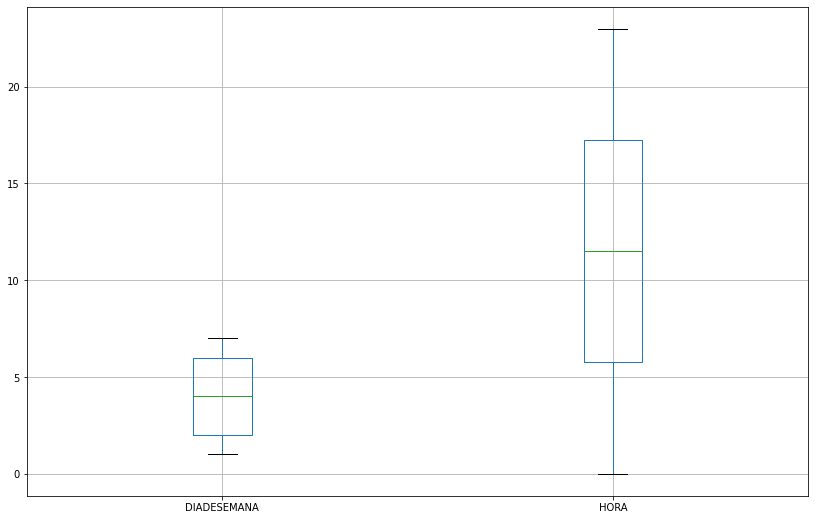

In [ ]:
df_reg[['DIADESEMANA','HORA']].boxplot(figsize=(14,9))

Generando datos de prueba y entrenamiento

In [ ]:
#CONJUNTO DE DATOS DE PRUEBA (20%)
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_reg, test_size=0.2, random_state=3, shuffle=True)
print(train)

      DIADESEMANA  HORA  SERVICIO
1042            6    10         0
588             1    12         0
2242            7    10         0
551             6    23         0
1037            6     5         0
...           ...   ...       ...
3000            4     0         0
1667            4    11         0
3321            3     9         0
1688            5     8         0
1898            7     2         0

[2860 rows x 3 columns]


In [ ]:
#datos de entrenamiento
train.shape

(2860, 3)

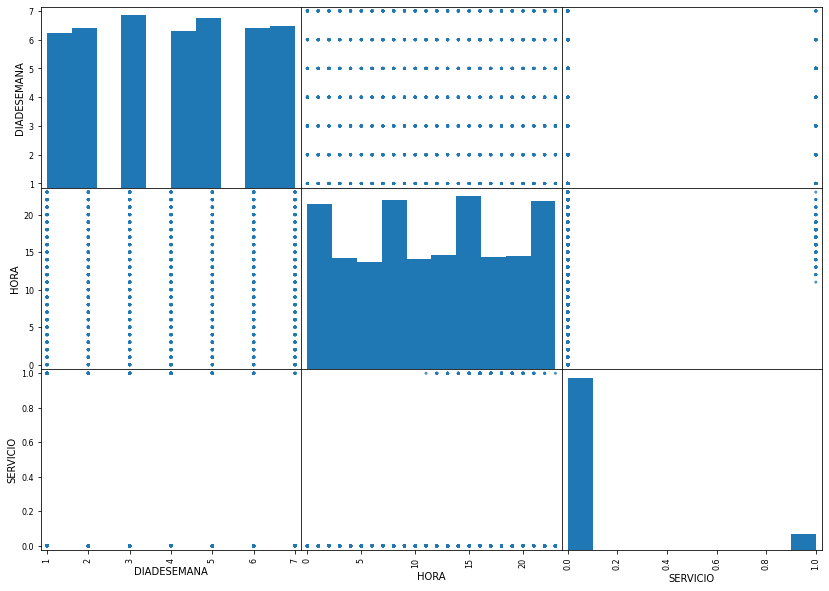

In [ ]:
#Matriz de Dispersion con MatPlotLib
pd.plotting.scatter_matrix(train.loc[:,['DIADESEMANA','HORA','SERVICIO']], figsize=(14,10), alpha=0.8)
plot.show()

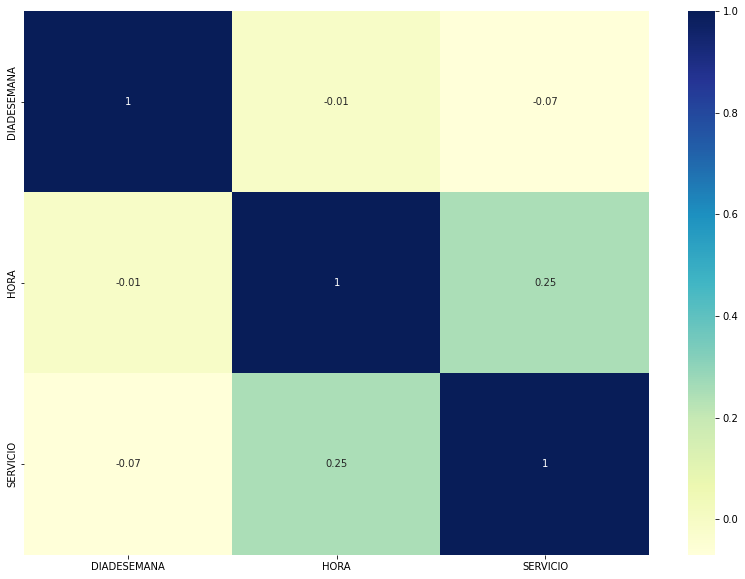

In [ ]:
correlation_matrix = train.corr().round(2) 
fig, heat = plot.subplots(figsize = (14,10))
heat = sns.heatmap(data=correlation_matrix, annot=True, cmap="YlGnBu")
plot.show()

In [ ]:
train.corr().SERVICIO.to_frame()

,SERVICIO
DIADESEMANA,-0.068639
HORA,0.245404
SERVICIO,1.000000


# Generación del modelo

In [ ]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
data = pd.DataFrame(std.fit_transform(train), columns=train.columns)
data.head()

,DIADESEMANA,HORA,SERVICIO
0,0.998798,-0.227844,-0.308134
1,-1.521550,0.061964,-0.308134
2,1.502868,-0.227844,-0.308134
3,0.998798,1.655913,-0.308134
4,0.998798,-0.952367,-0.308134


In [ ]:
yrl = data.SERVICIO
features = ['HORA',	'DIADESEMANA']
Xrl = data[features]

##Evaluación de modelos##

ALGORITMO DE LOS KNN